In [78]:
import yaml
import torch
import os

import numpy as np

from torch.utils.data import DataLoader
from torch import optim

from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal


# project modules
from vae import VAE
from utils import read_config

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
(
    validate,
    data_dir,
    train_batch_size,
    image_size,
    epochs,
    lr,
    beta,
    latent_dim,
    num_samples,
    checkpoints,
    label_idxs,
    t_idx,
) = read_config()

In [123]:
image_size = 64
transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

testset = CelebA(
    root="data", split="train", transform=transform, download=False
)

test_loader = DataLoader(
    dataset=testset,
    batch_size=16,
    shuffle=True,
    num_workers=8,
    drop_last=True,
)

In [294]:
model = torch.load("runs/Jan10_00-02-54_larschen/epoch_3/vae_model.pth")

In [125]:
for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx > 1:
         break

    torch.cuda.empty_cache()
    images = images.to(device)
    xs = torch.tensor(labels[:, label_idxs], dtype=torch.float32)
    ts = torch.tensor(labels[:, t_idx].unsqueeze(1), dtype=torch.float32)

In [324]:
image = images[15].permute(1, 2, 0)
image = image - image.min()
image = image / image.max()


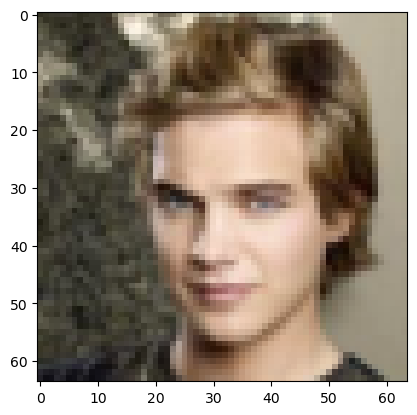

In [325]:
plt.imshow(image, interpolation="nearest")

In [251]:
with torch.no_grad():
    recon_batch, mu, log_var = model(images, xs, ts)

In [252]:
q_approx = MultivariateNormal(loc=mu, covariance_matrix=torch.diag_embed(torch.exp(log_var)))

In [253]:
sample = q_approx.sample()

In [322]:
z = sample[15, :]  #
#z = torch.randn(64)


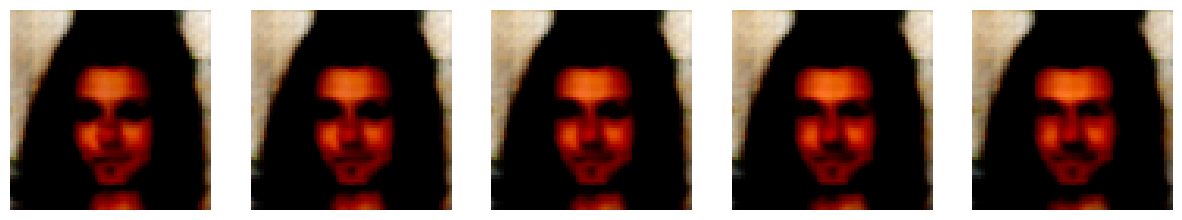

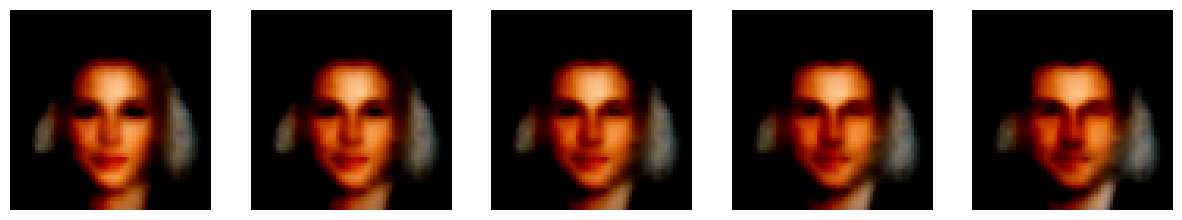

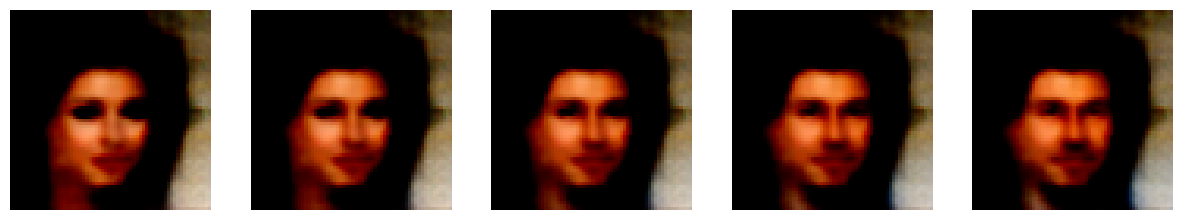

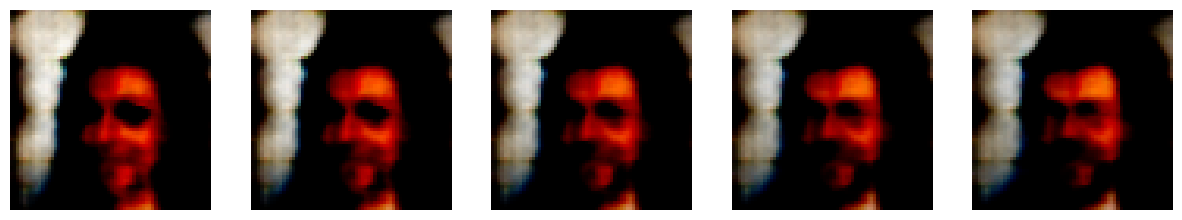

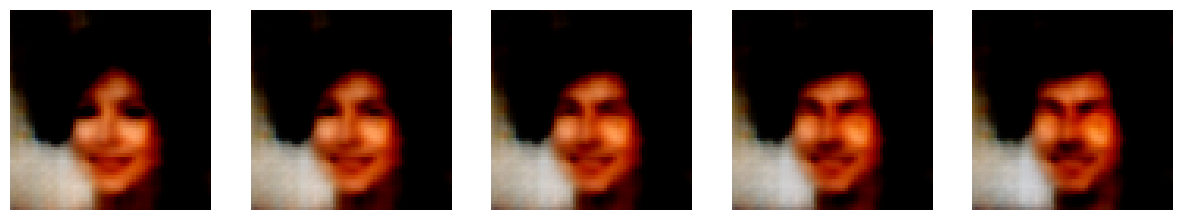

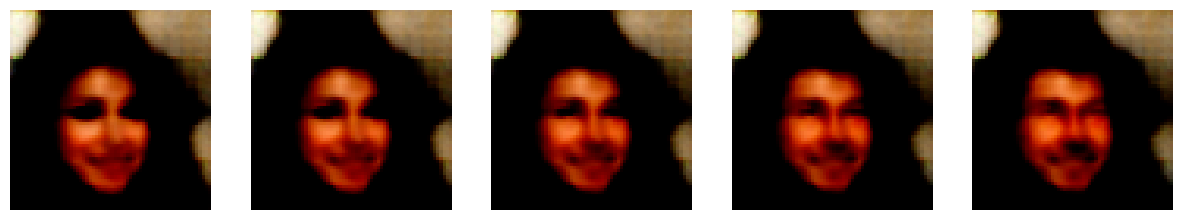

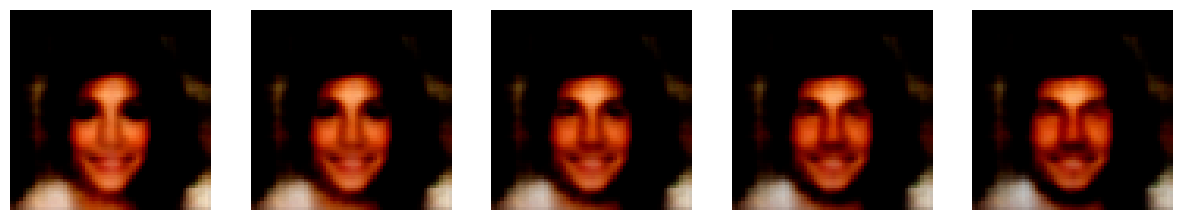

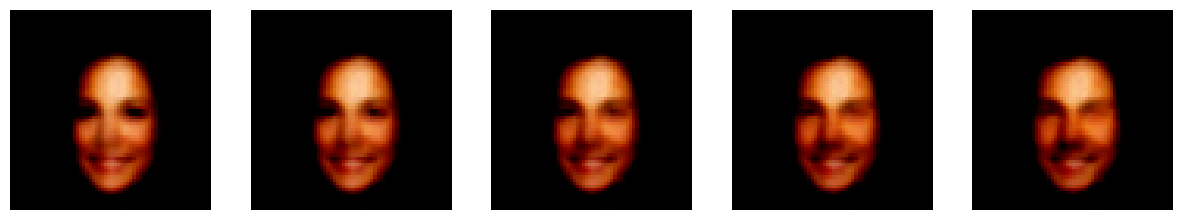

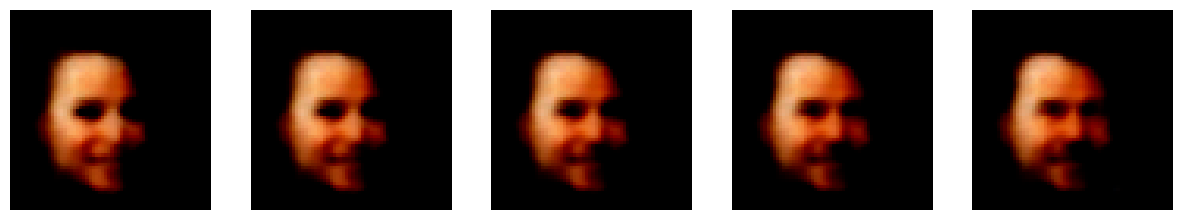

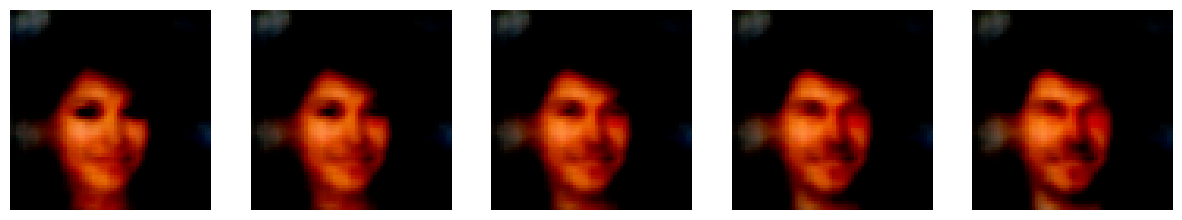

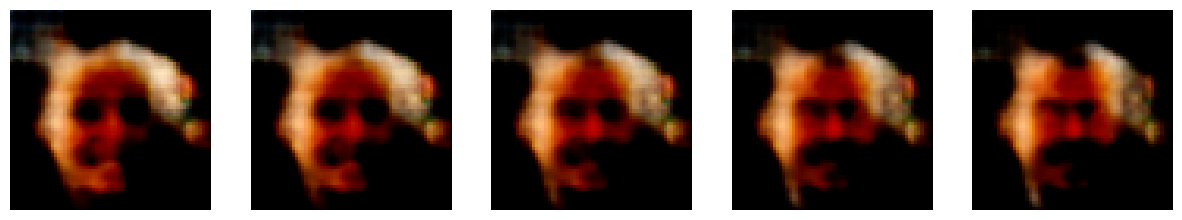

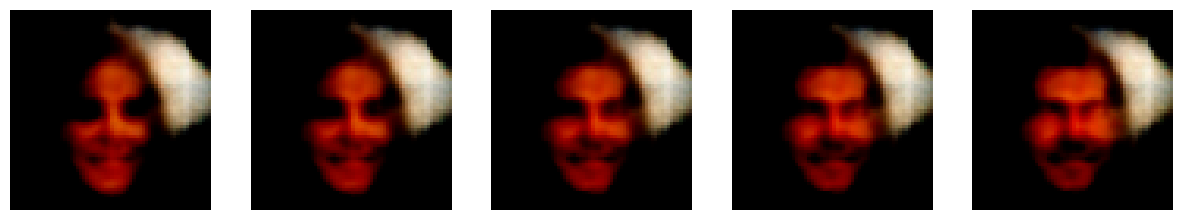

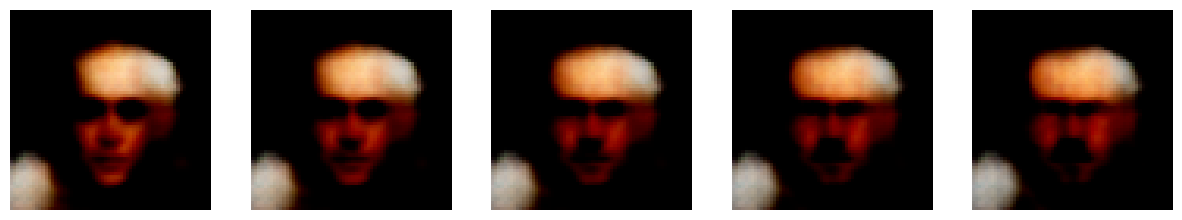

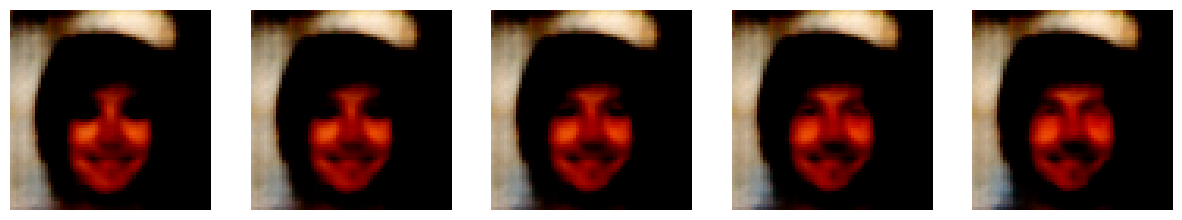

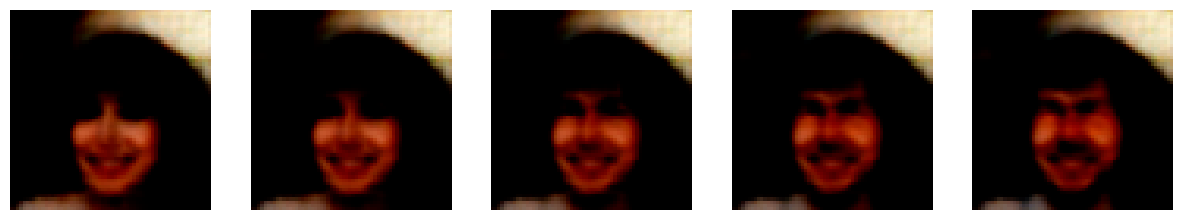

In [327]:
for j in range(15):
    z = sample[j, :]

    fig, axs = plt.subplots(1, 5, figsize=(15, 25))
    plt.axis("off")

    for i, sex in enumerate(np.linspace(-10, 10, 5)):
        with torch.no_grad():
            recon = model.decode(z.unsqueeze(0), torch.tensor([[i]]).to(device))

        reco_cond = recon.view(1, 3, 64, 64)
        reco_cond = reco_cond[0].permute(1, 2, 0)
        reco_cond = reco_cond - reco_cond.min()
        reco_cond = reco_cond / reco_cond.max()

        axs[i].imshow(reco_cond, interpolation="nearest")
        axs[i].set_axis_off()